# Assignment 1 for Clustering: Target Trial Emulation
- New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

- In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.
7. Deadline is: February 28, 2025 at 11:59 pm.

## I. Necessary Imports

In [555]:
import pandas as pd
import numpy as np
import os
import patsy
import joblib
import json
from IPython.display import display
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit
from dataclasses import dataclass
from typing import List, Optional, Any, Callable
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


## II. Class Definition and Required Functions

In [556]:
def stats_glm_logit(save_path):
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)

    def fit_model(numerator, denominator, data):
        formula = numerator
        try:
            model = smf.logit(formula, data).fit(disp=0)  # Suppress convergence messages
        except (np.linalg.LinAlgError, sm.tools.sm_exceptions.PerfectSeparationError):
            print(f"Warning: Perfect separation or singular matrix detected for {formula}. Falling back to intercept-only model.")
            formula = f"{formula.split('~')[0].strip()} ~ 1"
            model = smf.logit(formula, data).fit(disp=0)
        model_path = os.path.join(save_path, "logit_model.pkl")
        joblib.dump(model, model_path)
        model_details = {
            "numerator": numerator,
            "denominator": denominator,
            "model_type": "te_stats_glm_logit",
            "file_path": model_path
        }
        json.dump(model_details, open(os.path.join(save_path, "model_details.json"), "w"))
        return model
    
    return fit_model

@dataclass
class TEDatastore:
    data: pd.DataFrame = None

    def save_expanded_data(self, switch_data: pd.DataFrame):
        if self.data is None:
            self.data = switch_data
        else:
            self.data = pd.concat([self.data, switch_data], ignore_index=True)
        return self

@dataclass
class TEExpansion:
    chunk_size: int = 0
    datastore: TEDatastore = None
    first_period: int = 0
    last_period: float = float('inf')
    censor_at_switch: bool = False

class TrialSequence:
    def __init__(self, estimand, **kwargs):
        self.estimand = estimand
        self.data = None
        self.censor_weights = None
        self.switch_weights = None
        self.outcome_model = None
        self.expansion = None
        self.outcome_data = None

    def set_data(self, data):
        self.data = data
        self.data["followup_time"] = self.data.groupby("id")["period"].transform(
            lambda x: x[(self.data.loc[x.index, "censored"] == 1) | (self.data.loc[x.index, "outcome"] == 1)].min()
            if ((self.data.loc[x.index, "censored"] == 1) | (self.data.loc[x.index, "outcome"] == 1)).any()
            else x.max()
        )

    def show(self):
        print(f"Trial Sequence Object\nEstimand: {self.estimand}\n")
        if self.data is not None:
            display(self.data)
        else:
            print("No data set")
        print("\nIPW for informative censoring:")
        print(self.censor_weights if self.censor_weights is not None else "Not calculated.")
        if self.switch_weights is not None:
            print("\nIPW for treatment switch censoring:")
            print(self.switch_weights)
        print("\nOutcome model:")
        print(self.outcome_model if self.outcome_model is not None else "Not specified.")
        if self.outcome_data is not None:
            print("\nOutcome data:")
            print(self.outcome_data)
    

#Subclass of Trial Sequence, handles the PP (hehe) estimand
class TrialSequencePP(TrialSequence):
    def __init__(self, **kwargs):
        super().__init__("PP", **kwargs)
 
#Subclass of Trial Sequence, handles the ITT estimand
class TrialSequenceITT(TrialSequence):
    def __init__(self, **kwargs):
        super().__init__("ITT", **kwargs)

#trial_sequence function equivalent used in the article
def trial_sequence(estimand, **kwargs):
    estimand_classes = {
        "PP": TrialSequencePP,
        "ITT": TrialSequenceITT
    }

    if estimand not in estimand_classes:
        raise ValueError(f"{estimand} is not a valid estimand, choose either PP or ITT")
    
    return estimand_classes[estimand](**kwargs)


## III. Process

### 1. Setup
A sequence of target trials analysis starts by specifying which estimand will be used:

In [557]:
trial_pp = trial_sequence("PP")
trial_itt = trial_sequence("ITT")

### 2. Data Preparation
Next the user must specify the observational input data that will be used for the target trial emulation. Here we need to specify which columns contain which values and how they should be used.

In [558]:
data_censored = pd.read_csv("data_censored.csv")
print("Extracted Dummy Data")
display(data_censored)
data_censored["previous_treatment"] = data_censored["treatment"].shift(1).fillna(0)
#Setting the dataset to the data field
trial_pp.set_data(data_censored.copy())  # Create a separate copy
trial_itt.set_data(data_censored.copy())  


#Displaying the info stored in each class
trial_pp.show()

trial_itt.show()

Extracted Dummy Data


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
720,99,3,0,0,-0.747906,1,0.575268,68,2.750000,0,0,0
721,99,4,0,0,-0.790056,1,0.575268,69,2.833333,0,0,0
722,99,5,1,1,0.387429,1,0.575268,70,2.916667,0,0,0
723,99,6,1,1,-0.033762,1,0.575268,71,3.000000,0,0,0


Trial Sequence Object
Estimand: PP



,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,previous_treatment,followup_time
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,0.0,5
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,1.0,5
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,1.0,5
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,1.0,5
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,99,3,0,0,-0.747906,1,0.575268,68,2.750000,0,0,0,0.0,7
721,99,4,0,0,-0.790056,1,0.575268,69,2.833333,0,0,0,0.0,7
722,99,5,1,1,0.387429,1,0.575268,70,2.916667,0,0,0,0.0,7
723,99,6,1,1,-0.033762,1,0.575268,71,3.000000,0,0,0,1.0,7



IPW for informative censoring:
Not calculated.

Outcome model:
Not specified.
Trial Sequence Object
Estimand: ITT



,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,previous_treatment,followup_time
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,0.0,5
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,1.0,5
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,1.0,5
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,1.0,5
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,99,3,0,0,-0.747906,1,0.575268,68,2.750000,0,0,0,0.0,7
721,99,4,0,0,-0.790056,1,0.575268,69,2.833333,0,0,0,0.0,7
722,99,5,1,1,0.387429,1,0.575268,70,2.916667,0,0,0,0.0,7
723,99,6,1,1,-0.033762,1,0.575268,71,3.000000,0,0,0,1.0,7



IPW for informative censoring:
Not calculated.

Outcome model:
Not specified.


### 3. Weight Models
To adjust for the effects of informative censoring, inverse probability of censoring weights (IPCW) can be applied. To estimate these weights, we construct time-to-(censoring) event models. Two sets of models are fit for the two censoring mechanisms which may apply: censoring due to deviation from assigned treatment and other informative censoring.
#### 3.1 Censoring due to treatment switching
We specify model formulas to be used for calculating the probability of receiving treatment in the current period. Separate models are fitted for patients who had treatment = 1 and those who had treatment = 0 in the previous period. Stabilized weights are used by fitting numerator and denominator models.

There are optional arguments to specify columns which can include/exclude observations from the treatment models. These are used in case it is not possible for a patient to deviate from a certain treatment assignment in that period.

#### Necessary Functions

In [559]:
def set_switch_weight_model(self, numerator=None, denominator=None, model_fitter=None, eligible_wts_0=None, eligible_wts_1=None):
        if self.data is None:
            raise ValueError("set_data() before setting switch weight models")
        if self.estimand == "ITT":
            raise ValueError("Switching weights are not supported for intention-to-treat analyses")
        if eligible_wts_0 and eligible_wts_0 in self.data.columns:
            self.data = self.data.rename(columns={eligible_wts_0: "eligible_wts_0"})
        if eligible_wts_1 and eligible_wts_1 in self.data.columns:
            self.data = self.data.rename(columns={eligible_wts_1: "eligible_wts_1"})
        if numerator is None:
            numerator = "1"
        if denominator is None:
            denominator = "1"
        if "time_on_regime" in denominator:
            raise ValueError("time_on_regime should not be used in denominator.")
        formula_numerator = f"treatment ~ {numerator}"
        formula_denominator = f"treatment ~ {denominator}"
        self.switch_weights = {
            "numerator": formula_numerator,
            "denominator": formula_denominator,
            "model_fitter": "te_stats_glm_logit",
        }
        if model_fitter is not None:
            self.switch_weights["fitted_model_0_numerator"] = model_fitter(formula_numerator, denominator, self.data[self.data["previous_treatment"] == 0])
            self.switch_weights["fitted_model_1_numerator"] = model_fitter(formula_numerator, denominator, self.data[self.data["previous_treatment"] == 1])
            self.switch_weights["fitted_model_0_denominator"] = model_fitter(formula_denominator, denominator, self.data[self.data["previous_treatment"] == 0])
            self.switch_weights["fitted_model_1_denominator"] = model_fitter(formula_denominator, denominator, self.data[self.data["previous_treatment"] == 1])
            self.data["switch_prob_0"] = self.switch_weights["fitted_model_0_denominator"].predict(self.data[self.data["previous_treatment"] == 0])
            self.data["switch_prob_1"] = self.switch_weights["fitted_model_1_denominator"].predict(self.data[self.data["previous_treatment"] == 1])
            self.data["switch_weight"] = np.where(self.data["previous_treatment"] == 0, 
                                                  1 / self.data["switch_prob_0"], 
                                                  1 / self.data["switch_prob_1"])
            self.data["switch_weight"] = self.data["switch_weight"].fillna(1)
            print("Switch weights computed and stored in self.data")

def show_switch_weights(self):
    return self.switch_weights if self.switch_weights else "Not calculated"
    
TrialSequence.set_switch_weight_model = set_switch_weight_model
TrialSequence.show_switch_weights = show_switch_weights

In [560]:
path = "Models"
data_0 = trial_pp.data[trial_pp.data["previous_treatment"] == 0]
data_1 = trial_pp.data[trial_pp.data["previous_treatment"] == 1]
trial_pp.set_switch_weight_model(numerator="age", denominator="age + x1 + x3", model_fitter=stats_glm_logit(save_path=os.path.join(path, "switch_models")))
trial_pp.show_switch_weights()

Switch weights computed and stored in self.data


{'numerator': 'treatment ~ age',
 'denominator': 'treatment ~ age + x1 + x3',
 'model_fitter': 'te_stats_glm_logit',
 'fitted_model_0_numerator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973eb8a6f0>,
 'fitted_model_1_numerator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973f37f0b0>,
 'fitted_model_0_denominator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973f1e77d0>,
 'fitted_model_1_denominator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973f330a10>}

#### 3.2 Other informative censoring
In case there is other informative censoring occurring in the data, we can create similar models to estimate the IPCW. These can be used with all types of estimand. We need to specifycensor_event which is the column containing the censoring indicator.

#### Necessary Functions

In [561]:
def set_censor_weight_model(self, censor_event, numerator="1", denominator="1", pool_models="none", model_fitter=None):
    if model_fitter is None:
        model_fitter = stats_glm_logit()
    if censor_event not in self.data.columns:
        raise ValueError(f"'{censor_event}' must be a column in the dataset.")
    self.data["censored_inv"] = 1 - self.data[censor_event]
    formula_numerator = f"censored_inv ~ {numerator}"
    formula_denominator = f"censored_inv ~ {denominator}"
    self.censor_weights = {
        "numerator": formula_numerator,
        "denominator": formula_denominator,
        "pool_numerator": pool_models in ["numerator", "both"],
        "pool_denominator": pool_models == "both",
        "model_fitter": "te_stats_glm_logit"
    }
    if self.estimand == "PP":
        self.censor_weights["fitted_model_0_numerator"] = model_fitter(formula_numerator, denominator, self.data[self.data["previous_treatment"] == 0])
        self.censor_weights["fitted_model_1_numerator"] = model_fitter(formula_numerator, denominator, self.data[self.data["previous_treatment"] == 1])
        self.censor_weights["fitted_model_0_denominator"] = model_fitter(formula_denominator, denominator, self.data[self.data["previous_treatment"] == 0])
        self.censor_weights["fitted_model_1_denominator"] = model_fitter(formula_denominator, denominator, self.data[self.data["previous_treatment"] == 1])
    elif self.estimand == "ITT":
        self.censor_weights["fitted_model_numerator"] = model_fitter(formula_numerator, denominator, self.data)
        if not self.censor_weights["pool_denominator"]:
            self.censor_weights["fitted_model_0_denominator"] = model_fitter(formula_denominator, denominator, self.data[self.data["previous_treatment"] == 0])
            self.censor_weights["fitted_model_1_denominator"] = model_fitter(formula_denominator, denominator, self.data[self.data["previous_treatment"] == 1])

def show_censor_weights(self):
    return self.censor_weights if self.censor_weights else "Not calculated"


TrialSequence.set_censor_weight_model = set_censor_weight_model
TrialSequence.show_censor_weights = show_censor_weights

#### Execution

In [562]:
data_0 = trial_pp.data[trial_pp.data["previous_treatment"] == 0]
data_1 = trial_pp.data[trial_pp.data["previous_treatment"] == 1]
trial_pp.set_censor_weight_model(censor_event="censored", numerator="x2", denominator="x2 + x1", pool_models="none", model_fitter=stats_glm_logit(save_path=os.path.join(path, "censor_models")))
trial_pp.show_censor_weights()

{'numerator': 'censored_inv ~ x2',
 'denominator': 'censored_inv ~ x2 + x1',
 'pool_numerator': False,
 'pool_denominator': False,
 'model_fitter': 'te_stats_glm_logit',
 'fitted_model_0_numerator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973f104470>,
 'fitted_model_1_numerator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973f40e690>,
 'fitted_model_0_denominator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973f40eed0>,
 'fitted_model_1_denominator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973f40d070>}

In [563]:
data_0 = trial_itt.data[trial_itt.data["previous_treatment"] == 0]
data_1 = trial_itt.data[trial_itt.data["previous_treatment"] == 1]
trial_itt.set_censor_weight_model(censor_event="censored", numerator="x2", denominator="x2 + x1", pool_models="numerator", model_fitter=stats_glm_logit(save_path=os.path.join(path, "censor_models")))
trial_itt.show_censor_weights()

{'numerator': 'censored_inv ~ x2',
 'denominator': 'censored_inv ~ x2 + x1',
 'pool_numerator': True,
 'pool_denominator': False,
 'model_fitter': 'te_stats_glm_logit',
 'fitted_model_numerator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973d32fb30>,
 'fitted_model_0_denominator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973f330710>,
 'fitted_model_1_denominator': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x2973f3b8cb0>}

#### 4. Calculate Weights
Next we need to fit the individual models and combine them into weights. This is done with calculate_weights().

#### Necessary Functions

In [564]:
def calculate_weights(self, quiet=False):
    use_censor_weights = isinstance(self.censor_weights, dict) and (
        "fitted_model_0_denominator" in self.censor_weights or "fitted_model_numerator" in self.censor_weights
    )
    if self.estimand == "PP":
        if not (isinstance(self.switch_weights, dict) and "fitted_model_0_denominator" in self.switch_weights):
            raise ValueError("Switch weight models are not specified. Use set_switch_weight_model()")
        self._calculate_weights_trial_seq(quiet, switch_weights=True, censor_weights=use_censor_weights)
    elif self.estimand == "ITT":
        self._calculate_weights_trial_seq(quiet, switch_weights=False, censor_weights=use_censor_weights)
    else:
        raise ValueError(f"Unknown estimand: {self.estimand}")

def _calculate_weights_trial_seq(self, quiet, switch_weights, censor_weights):
    if switch_weights:
        if not quiet:
            print("Calculating switch weights...")
        switch_model_0 = self.switch_weights["fitted_model_0_denominator"]
        switch_model_1 = self.switch_weights["fitted_model_1_denominator"]
        mask_0 = self.data["previous_treatment"] == 0
        mask_1 = self.data["previous_treatment"] == 1
        self.data.loc[mask_0, "switch_prob"] = switch_model_0.predict(self.data[mask_0])
        self.data.loc[mask_1, "switch_prob"] = switch_model_1.predict(self.data[mask_1])
        self.data["switch_prob"] = self.data["switch_prob"].fillna(1.0)
        self.data["switch_weight"] = 1 / self.data["switch_prob"]
    if censor_weights:
        if not quiet:
            print("Calculating censor weights...")
        if self.estimand == "PP":
            censor_model_0 = self.censor_weights["fitted_model_0_denominator"]
            censor_model_1 = self.censor_weights["fitted_model_1_denominator"]
            mask_0 = self.data["previous_treatment"] == 0
            mask_1 = self.data["previous_treatment"] == 1
            self.data.loc[mask_0, "censor_prob"] = censor_model_0.predict(self.data[mask_0])
            self.data.loc[mask_1, "censor_prob"] = censor_model_1.predict(self.data[mask_1])
        elif self.estimand == "ITT":
            censor_model = self.censor_weights["fitted_model_numerator"]
            self.data["censor_prob"] = censor_model.predict(self.data)
        self.data["censor_prob"] = self.data["censor_prob"].fillna(1.0)
        self.data["censor_weight"] = 1 / self.data["censor_prob"]
    if switch_weights and censor_weights:
        self.data["final_weight"] = self.data["switch_weight"] * self.data["censor_weight"]
    elif switch_weights:
        self.data["final_weight"] = self.data["switch_weight"]
    elif censor_weights:
        self.data["final_weight"] = self.data["censor_weight"]
    if "switch_weight" in self.data.columns:
        print("\nWeight Summary for PP:")
        print(self.data[["switch_weight", "censor_weight", "final_weight"]].describe())
    else:
        print("\nWeight Summary for ITT:")
        print(self.data[["censor_weight", "final_weight"]].describe())

def show_weight_models(self):
    if self.switch_weights is None and self.censor_weights is None:
        print("No weight models have been set.")
        return

    if self.estimand == "PP":
        print("===== PP Estimand (No Pooling) =====")
        if self.censor_weights is not None:
            print("\n## Informative Censoring Weights ##")
            for prev_treatment in [0, 1]:
                for key in ["numerator", "denominator"]:
                    model_key = f"fitted_model_{prev_treatment}_{key}"
                    if model_key in self.censor_weights and self.censor_weights[model_key] is not None:
                        print(f"\n# {key.title()} Model (Previous Treatment = {prev_treatment})")
                        print(self.censor_weights[model_key].summary())
        
        if self.switch_weights is not None:
            print("\n## Treatment Switch Weights ##")
            for prev_treatment in [0, 1]:
                for key in ["numerator", "denominator"]:
                    model_key = f"fitted_model_{prev_treatment}_{key}"
                    if model_key in self.switch_weights and self.switch_weights[model_key] is not None:
                        print(f"\n# {key.title()} Model (Previous Treatment = {prev_treatment})")
                        print(self.switch_weights[model_key].summary())
    
    elif self.estimand == "ITT":
        print("===== ITT Estimand =====")
        if self.censor_weights is not None:
            print("\n## Informative Censoring Weights ##")
            if "fitted_model_numerator" in self.censor_weights and self.censor_weights["fitted_model_numerator"] is not None:
                print("\n# Numerator Model (Pooled)")
                print(self.censor_weights["fitted_model_numerator"].summary())
            for prev_treatment in [0, 1]:
                model_key = f"fitted_model_{prev_treatment}_denominator"
                if model_key in self.censor_weights and self.censor_weights[model_key] is not None:
                    print(f"\n# Denominator Model (Previous Treatment = {prev_treatment})")
                    print(self.censor_weights[model_key].summary())

TrialSequence.calculate_weights = calculate_weights
TrialSequence._calculate_weights_trial_seq = _calculate_weights_trial_seq
TrialSequence.show_weight_models = show_weight_models

#### Execution

In [565]:
trial_pp.calculate_weights()
trial_itt.calculate_weights()

Calculating switch weights...
Calculating censor weights...

Weight Summary for PP:
       switch_weight  censor_weight  final_weight
count     725.000000     725.000000    725.000000
mean        2.733546       1.090906      3.030777
std         1.732471       0.070613      2.072097
min         1.246125       1.013764      1.329844
25%         1.620576       1.048496      1.739213
50%         1.955091       1.068877      2.120418
75%         3.258089       1.107154      3.581826
max        12.525849       1.614490     13.890368
Calculating censor weights...

Weight Summary for ITT:
       censor_weight  final_weight
count     725.000000    725.000000
mean        1.088628      1.088628
std         0.044576      0.044576
min         1.019809      1.019809
25%         1.060133      1.060133
50%         1.080359      1.080359
75%         1.107915      1.107915
max         1.499109      1.499109


In [566]:
trial_pp.show_weight_models()

===== PP Estimand (No Pooling) =====

## Informative Censoring Weights ##

# Numerator Model (Previous Treatment = 0)
                           Logit Regression Results                           
Dep. Variable:           censored_inv   No. Observations:                  386
Model:                          Logit   Df Residuals:                      384
Method:                           MLE   Df Model:                            1
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.02782
Time:                        22:59:34   Log-Likelihood:                -116.34
converged:                       True   LL-Null:                       -119.67
Covariance Type:            nonrobust   LLR p-value:                  0.009874
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3297      0.185     12.625      0.000       1.968       2.691
x2           

In [567]:
trial_itt.show_weight_models()

===== ITT Estimand =====

## Informative Censoring Weights ##

# Numerator Model (Pooled)
                           Logit Regression Results                           
Dep. Variable:           censored_inv   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        22:59:34   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4481      0.141     17.415      0.000       2.173       2.724
x2            -0.4486      0.137     -3.2

### 5. Specify Outcome Model
Now we can specify the outcome model. Here we can include adjustment terms for any variables in the dataset. The numerator terms from the stabilised weight models are automatically included in the outcome model formula.

#### Necessary Functions

In [568]:
#STEP 5
def set_outcome_model(self, adjustment_terms=None, model_fitter=None):
    if self.data is None:
        raise ValueError("set_data() before defining the outcome model.")

    # Determine treatment variable
    treatment_var = "treatment"

    # Extract stabilized weight terms
    stabilised_weight_terms = []
    if self.switch_weights:
        stabilised_weight_terms.append(self.switch_weights["numerator"].split("~")[1].strip())
    if self.censor_weights:
        stabilised_weight_terms.append(self.censor_weights["numerator"].split("~")[1].strip())

    stabilised_weight_terms = " + ".join(stabilised_weight_terms) if stabilised_weight_terms else "1"

    # Default adjustment terms based on estimand
    if adjustment_terms is None:
        adjustment_terms = ["x1", "x2", "x3", "age"] if self.estimand == "PP" else ["x2"]
    elif isinstance(adjustment_terms, str):
        adjustment_terms = adjustment_terms.split(" + ")

    # Polynomial terms for time effects
    additional_terms = []
    #if "followup_time" in self.data.columns:
        #self.data["followup_time_squared"] = self.data["followup_time"] ** 2
        # additional_terms.extend(["followup_time", "I(followup_time**2)"])

    # Ensure 'period' and its squared term are included
    if "period" in self.data.columns:
        #self.data["period_squared"] = self.data["period"] ** 2
        additional_terms.extend(["trial_period", "I(trial_period**2)"])

    # Ensure unique terms using a set
    all_terms = set([treatment_var] + adjustment_terms + additional_terms)
    stabilised_terms = set(stabilised_weight_terms.split(" + "))  # Convert to set

    # Merge while keeping unique terms
    final_terms = all_terms | stabilised_terms
    final_terms.discard("1")  # Remove placeholder "1" if present

    # Construct formula
    formula = "outcome ~ " + " + ".join(sorted(final_terms))  # Sort for consistency

    # Ensure weights exist
    if "final_weight" not in self.data.columns:
        raise ValueError("Weights have not been calculated. Run calculate_weights() first.")

    # Default to logistic regression model fitter if none is provided
    if model_fitter is None:
        model_fitter = stats_glm_logit(save_path=None)

    # Store in outcome_model dictionary
    self.outcome_model = {
        "formula": formula,
        "treatment_var": treatment_var,
        "adjustment_vars": list(all_terms),  # Store as list for consistency
        "stabilised_weights_terms": " + ".join(sorted(stabilised_terms)),  # Keep as string for logging
        "model_fitter": model_fitter,
        "fitted": None  # Will be used in Step 8 (fit_msm)
    }

    return self

def show_outcome_model(self):
    return self.outcome_model if self.outcome_model else "Not calculated"

TrialSequence.set_outcome_model = set_outcome_model
TrialSequence.show_outcome_model = show_outcome_model

#### Execution

In [569]:
trial_pp.set_outcome_model()  
trial_itt.set_outcome_model(adjustment_terms="x2")  
trial_pp.show_outcome_model()


{'formula': 'outcome ~ I(trial_period**2) + age + treatment + trial_period + x1 + x2 + x3',
 'treatment_var': 'treatment',
 'adjustment_vars': ['x3',
  'x1',
  'age',
  'I(trial_period**2)',
  'trial_period',
  'treatment',
  'x2'],
 'stabilised_weights_terms': 'age + x2',
 'model_fitter': <function __main__.stats_glm_logit.<locals>.fit_model(numerator, denominator, data)>,
 'fitted': None}

### 6. Expand Trials
Now we are ready to create the data set with all of the sequence of target trials.

#### Necessary Functions

In [570]:
def set_expansion_options(self, output: TEDatastore, chunk_size: int = 0, first_period: int = 0, last_period: float = float('inf'), censor_at_switch: bool = False):
    
    self.expansion = TEExpansion(chunk_size = chunk_size, datastore = output, first_period = first_period, last_period = last_period, censor_at_switch = censor_at_switch)

    return self

TrialSequence.set_expansion_options = set_expansion_options

#### Execution

In [571]:
output = TEDatastore()
trial_pp.set_expansion_options(output, chunk_size=500, first_period = 0, last_period= float('inf'), censor_at_switch = True)
trial_itt.set_expansion_options(output, chunk_size=500, first_period = 0, last_period= float('inf'), censor_at_switch = False)

#### 6.1 Create Sequence of Trials Data

#### Necessary Functions

In [572]:
def expand_trials(self):
    data = self.data.copy()
    outcome_adj_vars = self.get_outcome_adjustment_vars()
    keeplist = list(set(['id', 'trial_period', 'followup_time', 'outcome', 'weight', 'treatment', 'x2', 'age'] + outcome_adj_vars))

    if 'wt' not in data.columns:
        data['wt'] = 1

    all_ids = data['id'].unique()
    if self.expansion.chunk_size == 0:
        ids_split = [all_ids]
    else:
        ids_split = np.array_split(all_ids, np.ceil(len(all_ids) / self.expansion.chunk_size))

    for ids in ids_split:
        switch_data = self._expand_chunk(data, ids, outcome_adj_vars, keeplist)
        self.expansion.datastore = self.expansion.datastore.save_expanded_data(switch_data)

    return self

def _expand_chunk(self, data: pd.DataFrame, ids: np.ndarray, outcome_adj_vars: List[str], keeplist: List[str]):
    chunk_data = data[data['id'].isin(ids)].copy()

    first_period = max([self.expansion.first_period, chunk_data[chunk_data['eligible'] == 1]['period'].min() or self.expansion.first_period])
    last_period = min([self.expansion.last_period, chunk_data[chunk_data['eligible'] == 1]['period'].max() or self.expansion.last_period])
    
    expanded_data = []
    for _, row in chunk_data.iterrows():
        if row['eligible'] == 1 and first_period <= row['period'] <= last_period:
            trial_start = row['period']
            trial_data = self._generate_trial_instance(row, chunk_data, trial_start, last_period, outcome_adj_vars, keeplist)
            expanded_data.append(trial_data)

    result = pd.concat(expanded_data, ignore_index=True) if expanded_data else pd.DataFrame()

    return result[keeplist]

def _generate_trial_instance(self, baseline_row: pd.Series, data: pd.DataFrame, trial_start: int, last_period: float, outcome_adj_vars: List[str], keeplist: List[str]):

    id_val = baseline_row['id']
    patient_data = data[data['id'] == id_val].sort_values('period')
    rows = []

    if pd.isna(last_period) or last_period == float('inf'):
        last_period_value = patient_data['period'].max()
    else:
        last_period_value = last_period

    # Convert float to integer to handle errors
    if pd.notna(last_period_value):
        last_period_int = int(np.floor(float(last_period_value)))
    else:
        last_period_int = int(trial_start)

    max_period_value = patient_data['period'].max()
    if pd.notna(max_period_value):
        max_period = int(np.floor(float(max_period_value)))
    else:
        max_period = last_period_int 

    last_period_int = int(last_period_int)
    max_period = int(max_period)

    for period in range(int(trial_start), int(min(last_period_int + 1, max_period + 1))):
        period_row = patient_data[patient_data['period'] == period].iloc[0] if not patient_data[patient_data['period'] == period].empty else None
        
        if period_row is None:
            continue

        if self.expansion.censor_at_switch and period > trial_start:
            prev_row = patient_data[patient_data['period'] == (period - 1)].iloc[0]
            if prev_row['treatment'] != period_row['treatment']:
                break  # Censor at switch

        trial_period = period - trial_start
        followup_time = period - trial_start
        final_weight = self.data[(self.data['id'] == id_val) & (self.data['period'] == period)]['final_weight'].iloc[0] if not self.data[(self.data['id'] == id_val) & (self.data['period'] == period)].empty else 1.0
        row_dict = {
            'id': id_val,
            'trial_period': trial_period,
            'followup_time': followup_time,
            'outcome': period_row['outcome'],
            'weight': final_weight,  
            'treatment': period_row['treatment'],
        }
        
        for var in outcome_adj_vars + ['age', 'x2']:
            if var in patient_data.columns:
                row_dict[var] = period_row.get(var, np.nan)
            else:
                row_dict[var] = np.nan 

        rows.append(pd.Series(row_dict))

    df = pd.DataFrame(rows)
    int_columns = ['id', 'trial_period', 'followup_time', 'outcome', 'treatment', 'age']
    df[int_columns] = df[int_columns].astype(int)

    return df

def get_outcome_adjustment_vars(self):
    return getattr(self.outcome_model, 'adjustment_vars', [])


TrialSequence.expand_trials = expand_trials
TrialSequence._expand_chunk = _expand_chunk
TrialSequence._generate_trial_instance = _generate_trial_instance
TrialSequence.get_outcome_adjustment_vars = get_outcome_adjustment_vars

#### Execution

In [ ]:
trial_pp.expand_trials()
trial_itt.expand_trials()
print("\nExpanded Data:")


Expanded Data:
Index(['followup_time', 'age', 'trial_period', 'id', 'treatment', 'x2',
       'outcome', 'weight'],
      dtype='object')


### 7. Load or Sample Expanded Data
Now that the expanded data has been created, we can prepare the data to fit the outcome model. For data that can fit comfortably in memory, this is a trivial step using load_expanded_data.

For large datasets, it may be necessary to sample from the expanded by setting the p_control argument. This sets the probability that an observation with outcome == 0 will be included in the loaded data. A seed can be set for reproducibility. Additionally, a vector of periods to include can be specified, e.g., period = 1:60, and/or a subsetting condition, subset_condition = "age > 65".

#### Necessary Functions

In [574]:
def load_expanded_data(self, p_control: Optional[float] = None, period: Optional[List[int]] = None, subset_condition: Optional[str] = None, seed: Optional[int] = None):
    
    if p_control is None:
        data_table = self.expansion.datastore.data.copy()
        data_table['sample_weight'] = 1
    else:
        np.random.seed(seed) if seed is not None else np.random.seed()
        data_table = self.expansion.datastore.data.copy()

        mask_outcome_1 = data_table['outcome'] == 1
        mask_outcome_0 = data_table['outcome'] == 0
        sampled_0 = data_table[mask_outcome_0].sample(frac=p_control, replace=False)
        data_table = pd.concat([data_table[mask_outcome_1], sampled_0])

        data_table.loc[mask_outcome_0, 'sample_weight'] = 1 / p_control if p_control > 0 else 1
        data_table.loc[mask_outcome_1, 'sample_weight'] = 1

    if period is not None:
        data_table = data_table[data_table['trial_period'].isin(period) | data_table['followup_time'].isin(period)]
    
    if subset_condition is not None:
        data_table = data_table.query(subset_condition)
    
    data_table = data_table.sort_values(['id', 'trial_period', 'followup_time'])
    data_table = data_table.reset_index(drop=True)
    
    self.outcome_data = data_table
    
    return self

TrialSequence.load_expanded_data = load_expanded_data

#### Execution

In [ ]:
trial_pp.load_expanded_data(p_control = 0.5, seed=1234)
trial_itt.load_expanded_data(p_control = 0.5, seed=1234)

Columns in self.outcome_data: ['followup_time', 'age', 'trial_period', 'id', 'treatment', 'x2', 'outcome', 'weight', 'sample_weight']


### 8. Fit Marginal Structural Model
To fit the outcome model we use fit_msm()

#### Necessary Functions

In [576]:
def fit_msm(self, weight_cols=["weight"], modify_weights=None, family="binomial"):
    if not self.outcome_model:
        raise ValueError("Outcome model not defined. Run set_outcome_model() first.")
    
    formula = self.outcome_model["formula"]
    print(f"Using formula from set_outcome_model: {formula}")
    
    weight_col = next(col for col in weight_cols if col in self.outcome_data.columns)
    data = self.outcome_data[~self.outcome_data[weight_col].isna()].copy()
    weights = data[weight_col].values
    
    if modify_weights:
        weights = modify_weights(weights)
    
    # Fit the MSM
    try:
        if family == "binomial":
            model = smf.logit(formula, data=data)
            fitted_model = model.fit(method='lbfgs', weights=weights, disp=0, maxiter=100)
        elif family == "gaussian":
            model = smf.ols(formula, data=data, weights=weights)
            fitted_model = model.fit()
        else:
            raise ValueError("Unsupported family. Use 'binomial' or 'gaussian'.")
    except np.linalg.LinAlgError as e:
        raise ValueError(f"Model fitting failed due to singular matrix: {e}.")
    
    print("MSM Fit Summary:")
    print(fitted_model.summary())
    self.outcome_model["fitted"] = fitted_model
    return fitted_model

TrialSequence.fit_msm = fit_msm

#### Execution

In [577]:
def winsorize_weights(weights):
    #99th percentile values
    return np.minimum(weights, np.quantile(weights, 0.99, method='nearest'))

trial_itt.fit_msm(weight_cols=["weight"], modify_weights=winsorize_weights)


Using formula from set_outcome_model: outcome ~ I(trial_period**2) + treatment + trial_period + x2
MSM Fit Summary:
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  970
Model:                          Logit   Df Residuals:                      965
Method:                           MLE   Df Model:                            4
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.01472
Time:                        22:59:38   Log-Likelihood:                -80.342
converged:                       True   LL-Null:                       -81.543
Covariance Type:            nonrobust   LLR p-value:                    0.6625
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.4163      0.570     -7.746      0.000      -5.5

c:\Users\Cedric\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


### 9. Inference
We use the predict() method to estimate survival probabilities or cumulative incidences for different values of assigned_treatment.

#### Necessary Functions

In [ ]:
def predict(self, newdata=None, predict_times=None, type="survival"):
    
    if newdata is None:
        if self.outcome_data is None:
            raise ValueError("outcome_data not available. Run load_expanded_data() first.")
        data = self.outcome_data.copy()
    else:
        data = newdata.copy()
    
    if predict_times is None:
        predict_times = np.arange(0, 11)
    
    predict_times = np.array(predict_times, dtype=int)
    
    model = self.outcome_model["fitted"]
    
    data_control = data.copy()
    data_control["treatment"] = 0  # Control group
    
    data_treated = data.copy()
    data_treated["treatment"] = 1  # Treated group
    
    # Predict probabilities for all data, then filter by predict_times
    preds_control = model.predict(data_control)
    preds_treated = model.predict(data_treated)
    
    survival_control = 1 - pd.Series(preds_control).groupby(data_control["followup_time"]).mean()
    survival_treated = 1 - pd.Series(preds_treated).groupby(data_treated["followup_time"]).mean()
    
    survival_diff = (survival_treated.reindex(predict_times).ffill().fillna(0) - survival_control.reindex(predict_times).ffill().fillna(0))
    
    ci_lower = survival_diff - 1.96 * np.std(survival_diff)
    ci_upper = survival_diff + 1.96 * np.std(survival_diff)
    
    # Step graph was ugly so we let gpt generate a smoother curve AHAHAHA
    fine_times = np.linspace(predict_times.min(), predict_times.max(), 100)
    
    interp_diff = interp1d(predict_times, survival_diff, kind='cubic', fill_value="extrapolate")
    interp_lower = interp1d(predict_times, ci_lower, kind='cubic', fill_value="extrapolate")
    interp_upper = interp1d(predict_times, ci_upper, kind='cubic', fill_value="extrapolate")
    
    smooth_diff = interp_diff(fine_times)
    smooth_lower = interp_lower(fine_times)
    smooth_upper = interp_upper(fine_times)
    
    plt.figure(figsize=(8, 5))
    plt.plot(fine_times, smooth_diff, label="Survival Difference", color="blue")
    plt.plot(fine_times, smooth_lower, linestyle='--', color="red", label="95% CI Lower Bound")
    plt.plot(fine_times, smooth_upper, linestyle='--', color="red", label="95% CI Upper Bound")
    
    plt.xlabel("Follow-up Time")
    plt.ylabel("Survival Difference")
    plt.title("Predicted Survival Difference Over Time")
    plt.legend()
    plt.show()

TrialSequence.predict = predict

#### Execution

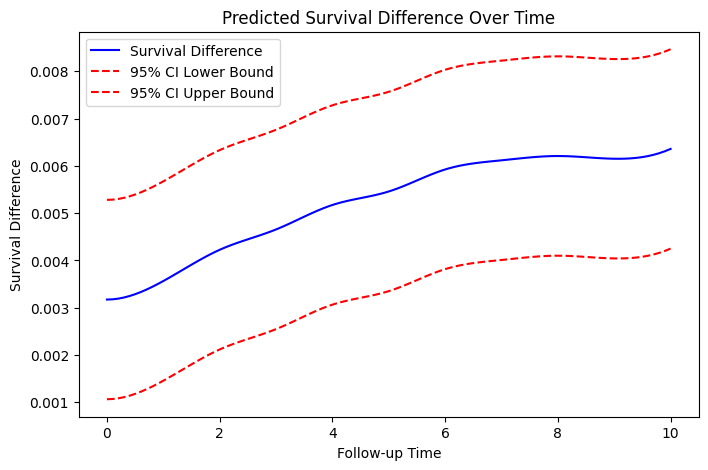

In [579]:
trial_itt.predict(type="difference")